In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🚀 ĐANG TẢI DỮ LIỆU...
   A: Model 30.4 (Strong)
   B: Model 29.0 ASL

📊 THỐNG KÊ CƠ BẢN:
Tiêu chí                  | Model 30.4 (Strong)  | Model 29.0 ASL      
---------------------------------------------------------------------------
Tổng số dòng dự đoán      | 4,486,180            | 4,486,180           
Số Protein (Unique ID)    | 224,309              | 224,309             
Số Nhãn (Unique Terms)    | 8,632                | 7,801               
Score Trung Bình          | 0.5546               | 0.5085              

🔗 Đang gộp (Merge) để tìm điểm chung/riêng...

🧩 ĐỘ CHỒNG LẮP (OVERLAP):
   - Chỉ Model 30.4 (Strong) có: 1,052,138 dòng (19.0%)
   - Chỉ Model 29.0 ASL có: 1,052,138 dòng (19.0%)
   - Cả hai cùng dự đoán:  3,434,042 dòng (62.0%)

📈 HỆ SỐ TƯƠNG QUAN (Pearson Correlation): 0.9030
   (> 0.9: Quá giống nhau | 0.6 - 0.8: Tốt cho Ensemble | < 0.5: Rất khác biệt)


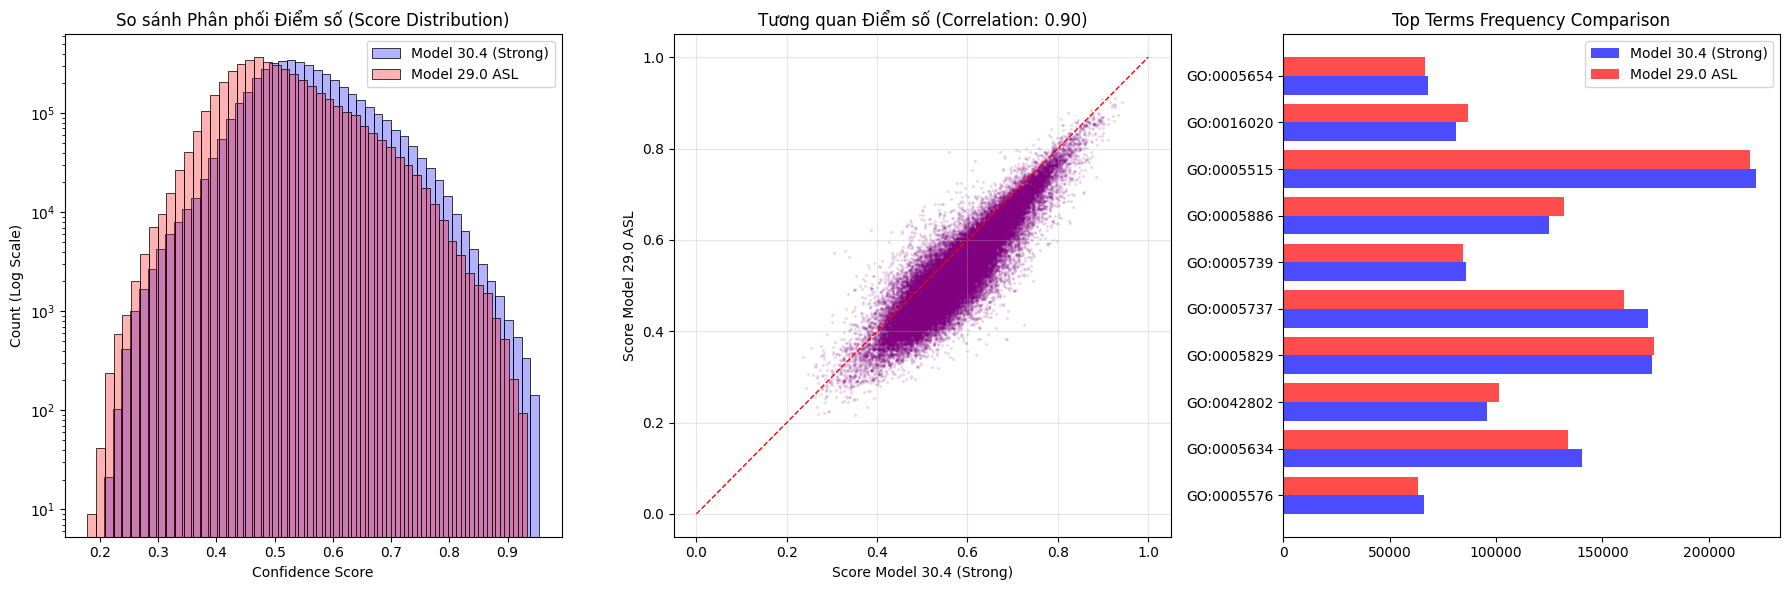

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# ==============================================================================
# 1. CẤU HÌNH ĐƯỜNG DẪN
# ==============================================================================
# File A (Thường là file điểm cao hơn)
FILE_A = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_2_ASL_ankh_esm2_prott5.tsv'
NAME_A = "Model 30.4 (Strong)"

# File B (File điểm thấp hơn hoặc model khác)
FILE_B = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_ASL_ankh_esm2_prott5.tsv'
NAME_B = "Model 29.0 ASL"

# Lấy mẫu để vẽ biểu đồ cho nhanh (tránh treo máy nếu file quá lớn)
SAMPLE_SIZE = 100000

# ==============================================================================
# 2. HÀM PHÂN TÍCH
# ==============================================================================
def compare_submissions(file_a, file_b, name_a, name_b):
    print(f"🚀 ĐANG TẢI DỮ LIỆU...")
    print(f"   A: {name_a}")
    print(f"   B: {name_b}")

    # Đọc file (Giả sử không header)
    df_a = pd.read_csv(file_a, sep='\t', header=None, names=['id', 'term', 'score_a'])
    df_b = pd.read_csv(file_b, sep='\t', header=None, names=['id', 'term', 'score_b'])

    print(f"\n📊 THỐNG KÊ CƠ BẢN:")
    print(f"{'Tiêu chí':<25} | {name_a:<20} | {name_b:<20}")
    print("-" * 75)
    print(f"{'Tổng số dòng dự đoán':<25} | {len(df_a):<20,} | {len(df_b):<20,}")
    print(f"{'Số Protein (Unique ID)':<25} | {df_a['id'].nunique():<20,} | {df_b['id'].nunique():<20,}")
    print(f"{'Số Nhãn (Unique Terms)':<25} | {df_a['term'].nunique():<20,} | {df_b['term'].nunique():<20,}")
    print(f"{'Score Trung Bình':<25} | {df_a['score_a'].mean():<20.4f} | {df_b['score_b'].mean():<20.4f}")

    # --- GỘP DỮ LIỆU ĐỂ SO SÁNH ---
    print("\n🔗 Đang gộp (Merge) để tìm điểm chung/riêng...")
    # Outer join để lấy tất cả
    merged = pd.merge(df_a, df_b, on=['id', 'term'], how='outer')

    # Fill NaN = 0 (Để tính tương quan)
    merged['score_a'] = merged['score_a'].fillna(0)
    merged['score_b'] = merged['score_b'].fillna(0)

    # Phân loại
    only_a = merged[(merged['score_a'] > 0) & (merged['score_b'] == 0)]
    only_b = merged[(merged['score_a'] == 0) & (merged['score_b'] > 0)]
    both   = merged[(merged['score_a'] > 0) & (merged['score_b'] > 0)]

    print(f"\n🧩 ĐỘ CHỒNG LẮP (OVERLAP):")
    print(f"   - Chỉ {name_a} có: {len(only_a):,} dòng ({len(only_a)/len(merged)*100:.1f}%)")
    print(f"   - Chỉ {name_b} có: {len(only_b):,} dòng ({len(only_b)/len(merged)*100:.1f}%)")
    print(f"   - Cả hai cùng dự đoán:  {len(both):,} dòng ({len(both)/len(merged)*100:.1f}%)")

    # Tính tương quan trên tập chung
    corr, _ = pearsonr(both['score_a'], both['score_b'])
    print(f"\n📈 HỆ SỐ TƯƠNG QUAN (Pearson Correlation): {corr:.4f}")
    print("   (> 0.9: Quá giống nhau | 0.6 - 0.8: Tốt cho Ensemble | < 0.5: Rất khác biệt)")

    return df_a, df_b, merged, corr

# ==============================================================================
# 3. VẼ BIỂU ĐỒ TRỰC QUAN
# ==============================================================================
df1, df2, df_merge, correlation = compare_submissions(FILE_A, FILE_B, NAME_A, NAME_B)

# Lấy mẫu để vẽ cho nhanh
plot_data = df_merge.sample(min(SAMPLE_SIZE, len(df_merge)), random_state=42)

plt.figure(figsize=(18, 6))

# --- Biểu đồ 1: Phân phối điểm số (Histogram) ---
plt.subplot(1, 3, 1)
sns.histplot(df1['score_a'], color='blue', alpha=0.3, label=NAME_A, bins=50)
sns.histplot(df2['score_b'], color='red', alpha=0.3, label=NAME_B, bins=50)
plt.title('So sánh Phân phối Điểm số (Score Distribution)')
plt.xlabel('Confidence Score')
plt.ylabel('Count (Log Scale)')
plt.yscale('log')
plt.legend()

# --- Biểu đồ 2: Tương quan (Scatter Plot) ---
plt.subplot(1, 3, 2)
# Chỉ vẽ những điểm mà cả 2 đều dự đoán > 0.01 để đỡ rối
subset = plot_data[(plot_data['score_a'] > 0.01) & (plot_data['score_b'] > 0.01)]
plt.scatter(subset['score_a'], subset['score_b'], alpha=0.1, s=2, c='purple')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1) # Đường chéo y=x
plt.title(f'Tương quan Điểm số (Correlation: {correlation:.2f})')
plt.xlabel(f'Score {NAME_A}')
plt.ylabel(f'Score {NAME_B}')
plt.grid(True, alpha=0.3)

# --- Biểu đồ 3: Top Terms Khác Biệt ---
# Tìm xem Model A thích dự đoán cái gì hơn Model B
plt.subplot(1, 3, 3)
top_terms_a = df1['term'].value_counts().head(10)
top_terms_b = df2['term'].value_counts().head(10)

# Gom lại thành DataFrame để vẽ
common_top = list(set(top_terms_a.index) | set(top_terms_b.index))
count_a = [df1[df1['term']==t].shape[0] for t in common_top]
count_b = [df2[df2['term']==t].shape[0] for t in common_top]

y_pos = np.arange(len(common_top))
plt.barh(y_pos - 0.2, count_a, 0.4, label=NAME_A, color='blue', alpha=0.7)
plt.barh(y_pos + 0.2, count_b, 0.4, label=NAME_B, color='red', alpha=0.7)
plt.yticks(y_pos, common_top)
plt.title('Top Terms Frequency Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CẤU HÌNH FILE (Bạn nhớ sửa lại đường dẫn FILE_B cho đúng file 28.8 nhé!)
# ==============================================================================
# Lưu ý: Trong tin nhắn bạn gửi 2 đường dẫn giống hệt nhau.
# Hãy trỏ FILE_B vào file cũ (28.8) để thấy sự khác biệt.

# File A (Thường là file điểm cao hơn)
FILE_A = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_2_ASL_ankh_esm2_prott5.tsv'
NAME_A = "Model 30.4 (Strong)"

# File B (File điểm thấp hơn hoặc model khác)
FILE_B = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_ASL_ankh_esm2_prott5.tsv'
NAME_B = "Model 29.0 ASL"

TOP_N_SHOW = 20 # Số lượng dự đoán muốn xem

# ==============================================================================
# 2. LOAD DỮ LIỆU
# ==============================================================================
print("⏳ Đang đọc 2 file submission...")
try:
    df_a = pd.read_csv(FILE_A, sep='\t', header=None, names=['id', 'term', 'score_a'])
    df_b = pd.read_csv(FILE_B, sep='\t', header=None, names=['id', 'term', 'score_b'])

    # Lấy danh sách Protein ID (Unique) từ file A làm chuẩn
    unique_ids = df_a['id'].unique()
    print(f"✅ Đã tải xong. Tổng cộng {len(unique_ids):,} proteins.")

except Exception as e:
    print(f"❌ Lỗi đọc file: {e}")
    print("👉 Hãy kiểm tra lại đường dẫn FILE_A và FILE_B.")

# ==============================================================================
# 3. HÀM SO SÁNH
# ==============================================================================
def compare_predictions(target_id):
    print(f"\n" + "="*80)
    print(f"🔍 SO SÁNH DỰ ĐOÁN CHO PROTEIN: {target_id}")
    print("="*80)

    # Lấy dữ liệu của protein này
    sub_a = df_a[df_a['id'] == target_id].sort_values('score_a', ascending=False).head(TOP_N_SHOW)
    sub_b = df_b[df_b['id'] == target_id].sort_values('score_b', ascending=False).head(TOP_N_SHOW)

    # Reset index để loop dễ hơn
    sub_a = sub_a.reset_index(drop=True)
    sub_b = sub_b.reset_index(drop=True)

    # In ra bảng so sánh side-by-side
    print(f"{'RANK':<5} | {NAME_A:<35} | {NAME_B:<35}")
    print("-" * 80)

    # Duyệt qua từng dòng (Rank 1, Rank 2...)
    max_len = max(len(sub_a), len(sub_b))

    for i in range(max_len):
        # Thông tin bên A
        str_a = ""
        if i < len(sub_a):
            term = sub_a.iloc[i]['term']
            score = sub_a.iloc[i]['score_a']
            str_a = f"{term} ({score:.4f})"

        # Thông tin bên B
        str_b = ""
        if i < len(sub_b):
            term = sub_b.iloc[i]['term']
            score = sub_b.iloc[i]['score_b']
            str_b = f"{term} ({score:.4f})"

        # Highlight sự khác biệt (Nếu cùng rank mà khác term)
        diff_mark = " "
        if i < len(sub_a) and i < len(sub_b):
            if sub_a.iloc[i]['term'] != sub_b.iloc[i]['term']:
                diff_mark = "*" # Đánh dấu nếu Top 1, Top 2... khác nhau

        print(f"#{i+1:<4} | {str_a:<35} | {str_b:<35} {diff_mark}")

    # --- PHÂN TÍCH SỰ KHÁC BIỆT ---
    set_a = set(sub_a['term'])
    set_b = set(sub_b['term'])

    only_in_a = set_a - set_b
    only_in_b = set_b - set_a

    print("-" * 80)
    if len(only_in_a) > 0:
        print(f"👉 {NAME_A} tìm ra thêm: {', '.join(list(only_in_a))}")
    if len(only_in_b) > 0:
        print(f"👉 {NAME_B} tìm ra thêm: {', '.join(list(only_in_b))}")

def check_by_index(index):
    if index < 0 or index >= len(unique_ids):
        print("❌ Index không hợp lệ.")
        return
    pid = unique_ids[index]
    print(f"(Protein thứ {index} trong danh sách là {pid})")
    compare_predictions(pid)

# ==============================================================================
# 4. CHẠY THỬ
# ==============================================================================

# Cách 1: Xem protein đầu tiên (Index 0)
check_by_index(0)

# Cách 2: Xem protein thứ 100
# check_by_index(100)

# Cách 3: Xem protein ngẫu nhiên (để test sự đa dạng)
import random
random_idx = random.randint(0, len(unique_ids)-1)
check_by_index(random_idx)

⏳ Đang đọc 2 file submission...
✅ Đã tải xong. Tổng cộng 224,309 proteins.
(Protein thứ 0 trong danh sách là A0JNW5)

🔍 SO SÁNH DỰ ĐOÁN CHO PROTEIN: A0JNW5
RANK  | Model 30.4 (Strong)                 | Model 29.0 ASL                     
--------------------------------------------------------------------------------
#1    | GO:0005515 (0.7240)                 | GO:0005515 (0.6950)                  
#2    | GO:0120013 (0.6750)                 | GO:0120013 (0.6330)                  
#3    | GO:0005829 (0.6160)                 | GO:0005739 (0.5850)                 *
#4    | GO:0005739 (0.6130)                 | GO:0005829 (0.5540)                 *
#5    | GO:0005783 (0.5920)                 | GO:0005737 (0.5540)                 *
#6    | GO:0005737 (0.5780)                 | GO:0120009 (0.5390)                 *
#7    | GO:0016020 (0.5760)                 | GO:0140268 (0.5240)                 *
#8    | GO:0005794 (0.5760)                 | GO:0005886 (0.5130)                 *
#9    | G

In [5]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CẤU HÌNH ĐƯỜNG DẪN
# ==============================================================================
FILE_A = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_2_ASL_ankh_esm2_prott5.tsv'
NAME_A = "Model 30.4 (Strong)"

FILE_B = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_ASL_ankh_esm2_prott5.tsv'
NAME_B = "Model 29.0 ASL"

# Chỉ quan tâm các nhãn có điểm số > 0.3 (để loại bỏ nhiễu khi so sánh)
SCORE_THRESHOLD = 0.1

# ==============================================================================
# 2. XỬ LÝ DỮ LIỆU
# ==============================================================================
print("⏳ Đang tải và phân tích sự khác biệt...")

# Đọc file
df_a = pd.read_csv(FILE_A, sep='\t', header=None, names=['id', 'term', 'score'])
df_b = pd.read_csv(FILE_B, sep='\t', header=None, names=['id', 'term', 'score'])

# Lọc bớt các dự đoán yếu để so sánh cho chất
df_a = df_a[df_a['score'] >= SCORE_THRESHOLD]
df_b = df_b[df_b['score'] >= SCORE_THRESHOLD]

# Gom nhóm: Mỗi Protein ID -> Tập hợp các Term nó dự đoán
# Set của Model A
preds_a = df_a.groupby('id')['term'].apply(set).to_dict()
# Set của Model B
preds_b = df_b.groupby('id')['term'].apply(set).to_dict()

# Lấy danh sách ID chung để so sánh
common_ids = list(set(preds_a.keys()) & set(preds_b.keys()))

print(f"✅ Đã tìm thấy {len(common_ids):,} protein có dự đoán mạnh (> {SCORE_THRESHOLD}) ở cả 2 file.")

# ==============================================================================
# 3. TÍNH TOÁN ĐỘ KHÁC BIỆT (JACCARD DISTANCE)
# ==============================================================================
diff_list = []

for pid in common_ids:
    set_a = preds_a[pid]
    set_b = preds_b[pid]

    # Jaccard Index = (Giao) / (Hợp)
    # Jaccard Distance = 1 - Jaccard Index (Càng gần 1 càng khác biệt)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)

    jaccard_dist = 1.0 - (intersection / union)

    # Chỉ lưu những ca khác biệt lớn (> 0.5)
    if jaccard_dist > 0.5:
        diff_list.append({
            'id': pid,
            'diff_score': jaccard_dist,
            'len_a': len(set_a),
            'len_b': len(set_b),
            'common': intersection
        })

# Sắp xếp để lấy những ca khác biệt nhất lên đầu
diff_df = pd.DataFrame(diff_list).sort_values(by='diff_score', ascending=False)

# ==============================================================================
# 4. HIỂN THỊ KẾT QUẢ
# ==============================================================================
print(f"\n🎯 TÌM THẤY {len(diff_df)} PROTEIN CÓ DỰ ĐOÁN KHÁC BIỆT LỚN!")
print("-" * 80)
print(f"{'Protein ID':<15} | {'Độ Lệch':<10} | {'SL Nhãn A':<10} | {'SL Nhãn B':<10} | {'Chung nhau':<10}")
print("-" * 80)

# In Top 10 ca khác biệt nhất
for idx, row in diff_df.head(10).iterrows():
    print(f"{row['id']:<15} | {row['diff_score']:.2f}       | {row['len_a']:<10} | {row['len_b']:<10} | {row['common']:<10}")

print("-" * 80)

# ==============================================================================
# 5. SOI CHI TIẾT 1 PROTEIN KHÁC BIỆT NHẤT
# ==============================================================================
if len(diff_df) > 0:
    top_diff_id = diff_df.iloc[0]['id']

    print(f"\n🔥 SOI CHI TIẾT PROTEIN KHÁC BIỆT NHẤT: {top_diff_id}")

    terms_a = preds_a[top_diff_id]
    terms_b = preds_b[top_diff_id]

    only_a = terms_a - terms_b
    only_b = terms_b - terms_a
    both = terms_a & terms_b

    print(f"\n1. {NAME_A} tìm thấy riêng ({len(only_a)} nhãn):")
    print(f"   {list(only_a)[:10]} ...") # In tối đa 10 cái

    print(f"\n2. {NAME_B} tìm thấy riêng ({len(only_b)} nhãn):")
    print(f"   {list(only_b)[:10]} ...")

    print(f"\n3. Cả hai cùng đồng ý ({len(both)} nhãn):")
    print(f"   {list(both)[:10]} ...")

⏳ Đang tải và phân tích sự khác biệt...
✅ Đã tìm thấy 224,309 protein có dự đoán mạnh (> 0.1) ở cả 2 file.

🎯 TÌM THẤY 39585 PROTEIN CÓ DỰ ĐOÁN KHÁC BIỆT LỚN!
--------------------------------------------------------------------------------
Protein ID      | Độ Lệch    | SL Nhãn A  | SL Nhãn B  | Chung nhau
--------------------------------------------------------------------------------
P0CV72          | 0.89       | 20         | 20         | 4         
P0DJN8          | 0.89       | 20         | 20         | 4         
Q54P45          | 0.86       | 20         | 20         | 5         
P0DY20          | 0.86       | 20         | 20         | 5         
Q54FU9          | 0.86       | 20         | 20         | 5         
Q47268          | 0.86       | 20         | 20         | 5         
Q553S5          | 0.82       | 20         | 20         | 6         
P0DSH1          | 0.82       | 20         | 20         | 6         
K7LFJ0          | 0.82       | 20         | 20         | 6         

In [6]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CẤU HÌNH (Sửa lại đường dẫn file của bạn)
# ==============================================================================
# ID Protein cần soi
TARGET_ID = "Q08311"

# File A (Model Mạnh - 30.4)
FILE_A = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_2_ASL_ankh_esm2_prott5.tsv'
NAME_A = "Model 30.4 (Strong)"

FILE_B = '/content/drive/MyDrive/CAFA6_Submission/submission_29.0_ASL_ankh_esm2_prott5.tsv'
NAME_B = "Model 29.0 ASL"

# ==============================================================================
# 2. XỬ LÝ
# ==============================================================================
print(f"🚀 Đang tìm kiếm protein {TARGET_ID} trong 2 file...")

def get_protein_data(filepath, target_id):
    # Đọc file theo chunk để đỡ tốn RAM nếu file quá lớn,
    # nhưng với file submission bình thường thì read_csv ok.
    # Tuy nhiên để nhanh, ta chỉ lấy dòng có chứa ID đó (nếu file đã sort)
    # Ở đây mình dùng cách đơn giản nhất: load hết lọc sau.
    try:
        df = pd.read_csv(filepath, sep='\t', header=None, names=['id', 'term', 'score'])
        subset = df[df['id'] == target_id].sort_values('score', ascending=False)
        return subset
    except Exception as e:
        print(f"❌ Lỗi đọc file {filepath}: {e}")
        return pd.DataFrame()

# Load dữ liệu riêng cho P92520
df_a = get_protein_data(FILE_A, TARGET_ID)
df_b = get_protein_data(FILE_B, TARGET_ID)

if len(df_a) == 0 and len(df_b) == 0:
    print(f"❌ Không tìm thấy ID {TARGET_ID} trong cả 2 file!")
else:
    print(f"✅ Đã tìm thấy dữ liệu.")
    print(f"   - {NAME_A}: {len(df_a)} nhãn")
    print(f"   - {NAME_B}: {len(df_b)} nhãn")

    # ==========================================================================
    # 3. SO SÁNH TRỰC QUAN (SIDE-BY-SIDE)
    # ==========================================================================
    print("\n" + "="*85)
    print(f"🧬 SO SÁNH TOP 15 DỰ ĐOÁN CHO: {TARGET_ID}")
    print("="*85)
    print(f"{'RANK':<5} | {NAME_A:<35} | {NAME_B:<35} | {'GHI CHÚ'}")
    print("-" * 85)

    max_len = 15
    for i in range(max_len):
        # Lấy info bên A
        term_a, score_a = "", 0.0
        if i < len(df_a):
            term_a = df_a.iloc[i]['term']
            score_a = df_a.iloc[i]['score']
            str_a = f"{term_a} ({score_a:.3f})"
        else:
            str_a = "---"

        # Lấy info bên B
        term_b, score_b = "", 0.0
        if i < len(df_b):
            term_b = df_b.iloc[i]['term']
            score_b = df_b.iloc[i]['score']
            str_b = f"{term_b} ({score_b:.3f})"
        else:
            str_b = "---"

        # So sánh
        note = ""
        if term_a and term_b:
            if term_a == term_b:
                diff = score_a - score_b
                if diff > 0.2: note = f"A tự tin hơn (+{diff:.2f})"
                elif diff < -0.2: note = f"B tự tin hơn ({diff:.2f})"
            else:
                note = "⚡ KHÁC NHÃN"

        print(f"#{i+1:<4} | {str_a:<35} | {str_b:<35} | {note}")

    # ==========================================================================
    # 4. PHÂN TÍCH SỰ KHÁC BIỆT (SET DIFFERENCE)
    # ==========================================================================
    # Chỉ xét các nhãn có điểm số > 0.1 để bỏ qua nhiễu
    set_a = set(df_a[df_a['score'] > 0.1]['term'])
    set_b = set(df_b[df_b['score'] > 0.1]['term'])

    only_in_a = set_a - set_b
    only_in_b = set_b - set_a

    print("\n" + "="*85)
    print("🔍 PHÂN TÍCH SỰ KHÁC BIỆT (Chỉ tính các nhãn Score > 0.1)")
    print("-" * 85)

    if len(only_in_a) > 0:
        print(f"👉 {NAME_A} phát hiện thêm ({len(only_in_a)} nhãn):")
        # In kèm điểm số để xem có chắc chắn không
        for t in list(only_in_a)[:10]:
            sc = df_a[df_a['term']==t]['score'].values[0]
            print(f"   + {t} (Score: {sc:.3f})")
    else:
        print(f"👉 {NAME_A} không tìm thấy nhãn mới nào so với B.")

    print("-" * 40)

    if len(only_in_b) > 0:
        print(f"👉 {NAME_B} phát hiện riêng ({len(only_in_b)} nhãn) - Có thể là nhiễu?:")
        for t in list(only_in_b)[:10]:
            sc = df_b[df_b['term']==t]['score'].values[0]
            print(f"   - {t} (Score: {sc:.3f})")
    else:
        print(f"👉 {NAME_B} hoàn toàn nằm trong tập dự đoán của A.")

    print("="*85)

🚀 Đang tìm kiếm protein Q08311 trong 2 file...
✅ Đã tìm thấy dữ liệu.
   - Model 30.4 (Strong): 20 nhãn
   - Model 29.0 ASL: 20 nhãn

🧬 SO SÁNH TOP 15 DỰ ĐOÁN CHO: Q08311
RANK  | Model 30.4 (Strong)                 | Model 29.0 ASL                      | GHI CHÚ
-------------------------------------------------------------------------------------
#1    | GO:0005515 (0.664)                  | GO:0005515 (0.606)                  | 
#2    | GO:0005737 (0.581)                  | GO:0005737 (0.536)                  | 
#3    | GO:0005829 (0.568)                  | GO:0019863 (0.503)                  | ⚡ KHÁC NHÃN
#4    | GO:0030254 (0.553)                  | GO:0005634 (0.502)                  | ⚡ KHÁC NHÃN
#5    | GO:0042802 (0.548)                  | GO:0005829 (0.500)                  | ⚡ KHÁC NHÃN
#6    | GO:0005634 (0.535)                  | GO:0004867 (0.487)                  | ⚡ KHÁC NHÃN
#7    | GO:0005576 (0.512)                  | GO:0042802 (0.482)                  | ⚡ KHÁC NHÃN
#